# Assignment 4
This assignment on convolutional neural networks and object detection has two parts. The first part has multiple questions. Put your answers in the solution blocks. The second part is a programming assignment. The total points for this assignment is 10.

**Due: Dec. 9, 11:59PM**


To submit your assignment, print the notebook with all outputs included and upload the PDF to Catcourse.

## Part I Questions on neural networks and object detection (4 points)

1. (1 point) Your model for classifying different dog species is getting a high training set error. Which of the followings are promising things to try to improve your classifier? Check all that apply.

(a)	Use a bigger neural network

(b)	Get more training data

(c)	Increase the weight regularization parameter

(d)	Train for longer epochs

Solution: a,b,d

2. (1 point) Which of the following network is for instance segmetnation?

 (a) AlexNet

 (b) Fast R-CNN

 (c) Faster R-CNN

 (d) Mask R-CNN


Solution: D

3. (1 point) What is the number of parameters including bias for 1x1 convolution layer with input size 64x64x16(HxWxC)?

Solution: 16

4. (1 point) Describle the difference between two-stage object detector and single-stage object detector.

Solution:

single stage is faster and simpler by directly predicting bounds and probabilities whereas two stage has the proposal generation and object detection steps

## Part II Non-maximum suppression for object detection (6 points)

You are supposed to implement non-maximum suppression for object detection. One of the most common problems with object detection algorithms is that rather than detecting an object just once, they might detect it multiple times. Take as an example the image below:

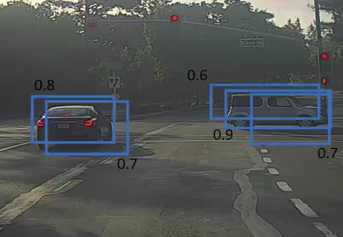

In the previous image, there are multiple boxes detecting the same car. The Non-Max Suppression technique tries to clean up this prediction to get only a single detection per object.

It first takes the detection with highest probability. In the above image, it will select the bounding box with 0.9 prediction. Then it will supress the boxes with high IoU with respect to the previoulsy selected one. So, the boxes with 0.6 and 0.7 probabilities will be suppressed in our example.

Let's first implement a function for Intersection-Over-Union (IoU). Consier two boxes bellow. IoU = Area of the yellow box (Intersection) / Area of the green box (Union)

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/12/Screenshot-from-2018-11-16-13-07-50.png" height=300/> <img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/12/Screenshot-from-2018-11-16-13-12-02.png" height=300/>

In [7]:
import numpy as np

# complete the function bellow
def iou(box1, box2):
  ## box = [x1, y1, x2, y2] where x1, y1 is the top left corner of the box and x2, y2 is the bottom right corner of the box

  # determine the (x, y)-coordinates of the intersection rectangle
  xi1 = max(box1[0], box2[0]) # want larger value between boxes (l -> r) gives us inner left x bound
  yi1 = max(box1[1], box2[1]) # want larger value (t -> b) gives us inner y bound for top of box
  xi2 = min(box1[2], box2[2])
  yi2 = min(box1[3], box2[3])

  # compute the area of intersection rectangle
  inter_area = max(0, yi2 - yi1) * max(0, xi2 - xi1)

  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

  # compute the intersection over union by taking the intersection area and dividing it by the box1 area + box2 area - the interesection area
  union_area = box1_area + box2_area - inter_area

  iou = inter_area / float(union_area)
  return iou

Now, we can see if our function is correct. First, we can try with two identical boxes, the IoU should be 1.

In [8]:
box1 =[10, 50, 30, 80] # To Complete
box2 = [10, 50, 30, 80]# To Complete
print(iou(box1, box2))

1.0


In the following code, we can find the IoU of two boxes with no intersection. The IoU should be 0.

In [9]:
box1 = [10, 50, 30, 80]
box2 = [40, 50, 50, 80]
print(iou(box1, box2))

0.0


In the following code, we will create a nms function. But, it is important to modify our previous IoU function. The IoU function created before, finds the IoU between two boxes, but we would like to find the IoU between one box and many others.

In [19]:
# complete the function bellow
def iou_many(box, boxes):
  ## box = [x1, y1, x2, y2] where x1, y1 is the top left corner of the box and x2, y2 is the bottom right corner of the box
  ## boxes = N x [xn1, yn1, xn2, yn2]
  # Return a list of IoU scores with box and each one in boxes

  x1, y1, x2, y2 = box
  ious = []

  for other_box in boxes:
    # 0 -> other box coords
    x1o, y1o, x2o, y2o = other_box

    # find intersection same as before but for each other box
    xi1 = max(x1, x1o) # left bound
    yi1 = max(y1, y1o) # top bound
    xi2 = min(x2, x2o) # right bound
    yi2 = min(y2, y2o) # bottom bound

    inter_area = max(0, yi2 - yi1) * max(0, xi2 - xi1)

    box_area = (x2 - x1) * (y2 - y1)
    other_box_area = (x2o - x1o) * (y2o - y1o)

    # compute the intersection over union by taking the intersection area and dividing it by the box1 area + box2 area - the interesection area
    union_area = box_area + other_box_area - inter_area

    iou = inter_area / float(union_area)
    ious.append(iou)

  return ious

In [48]:
# complete the function bellow
def nms(boxes, scores, IoUthreshold):
  # param1: boxes is a list of boxes = N x [xn1, yn1, xn2, yn2]
  # param2: scores is a list of confidences for boxes, e.g., [0.8, 0.2, 0.5, 0.4]
  # param3: IoUthreshold is the threshold of IoU when comparing boxes
  # returns: indices of selected boxes

  # if there are no boxes, return an empty list
  if len(boxes) == 0:
    return []

  # initialize the list of picked indexes
  pick = []

  # Sort the indices by the score
  idxs = np.argsort(scores)

  # keep looping while some indexes still remain in the indexes list
  while len(idxs) > 0:

    # Choose the index with highest score and add the index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    # Get the IoU between the box with highest score and the boxes remained in the indexes list
    temp_boxes = [boxes[j] for j in idxs[:last]] # grab picked boxes
    ious = np.array(iou_many(boxes[i], temp_boxes))
    
    # delete all indexes from the index list that have overlap > overlapThresh
    idxs = np.delete(idxs, np.where(ious > IoUthreshold))
    idxs = np.delete(idxs, idxs.shape[0] - 1)

  # return only the indices of the bounding boxes that were picked
  return np.asarray(pick)

Let's test the function with the example car boxes bellow.

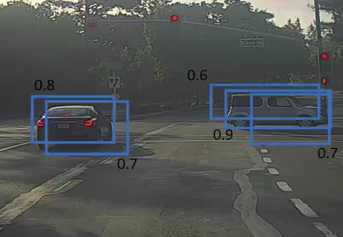

In [49]:
boxes = np.array([[29, 94, 110, 140],
         [40, 100, 123, 153],
         [206, 82, 316, 118],
         [222, 92, 328, 127],
         [250, 94, 328, 142]])
scores = [0.8, 0.7, 0.6, 0.9, 0.7]

# show results of using a large IoU threshold
print(nms(boxes, scores, IoUthreshold=0.1))

# show results of using a small IoU threshold
print(nms(boxes, scores, IoUthreshold=0.9))

[3 0]
[3 0 4 1 2]


Question: If we would like less remaining bounding boxes, should we choose a large or small IoU threshold?

Solution: larger. As shown by the output above, larger threshold empirically generates fewer boxes. Intuitively, larger threshold means the boxes will need to overlap more to be considered duplicates. this restriction means fewer boxes make it through the suppression